In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, matthews_corrcoef, roc_auc_score
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split

Number of 1s in y (no drop): 363
Number of 0s in y (drop >= 1%): 385
Class balance: 48.53% positive class


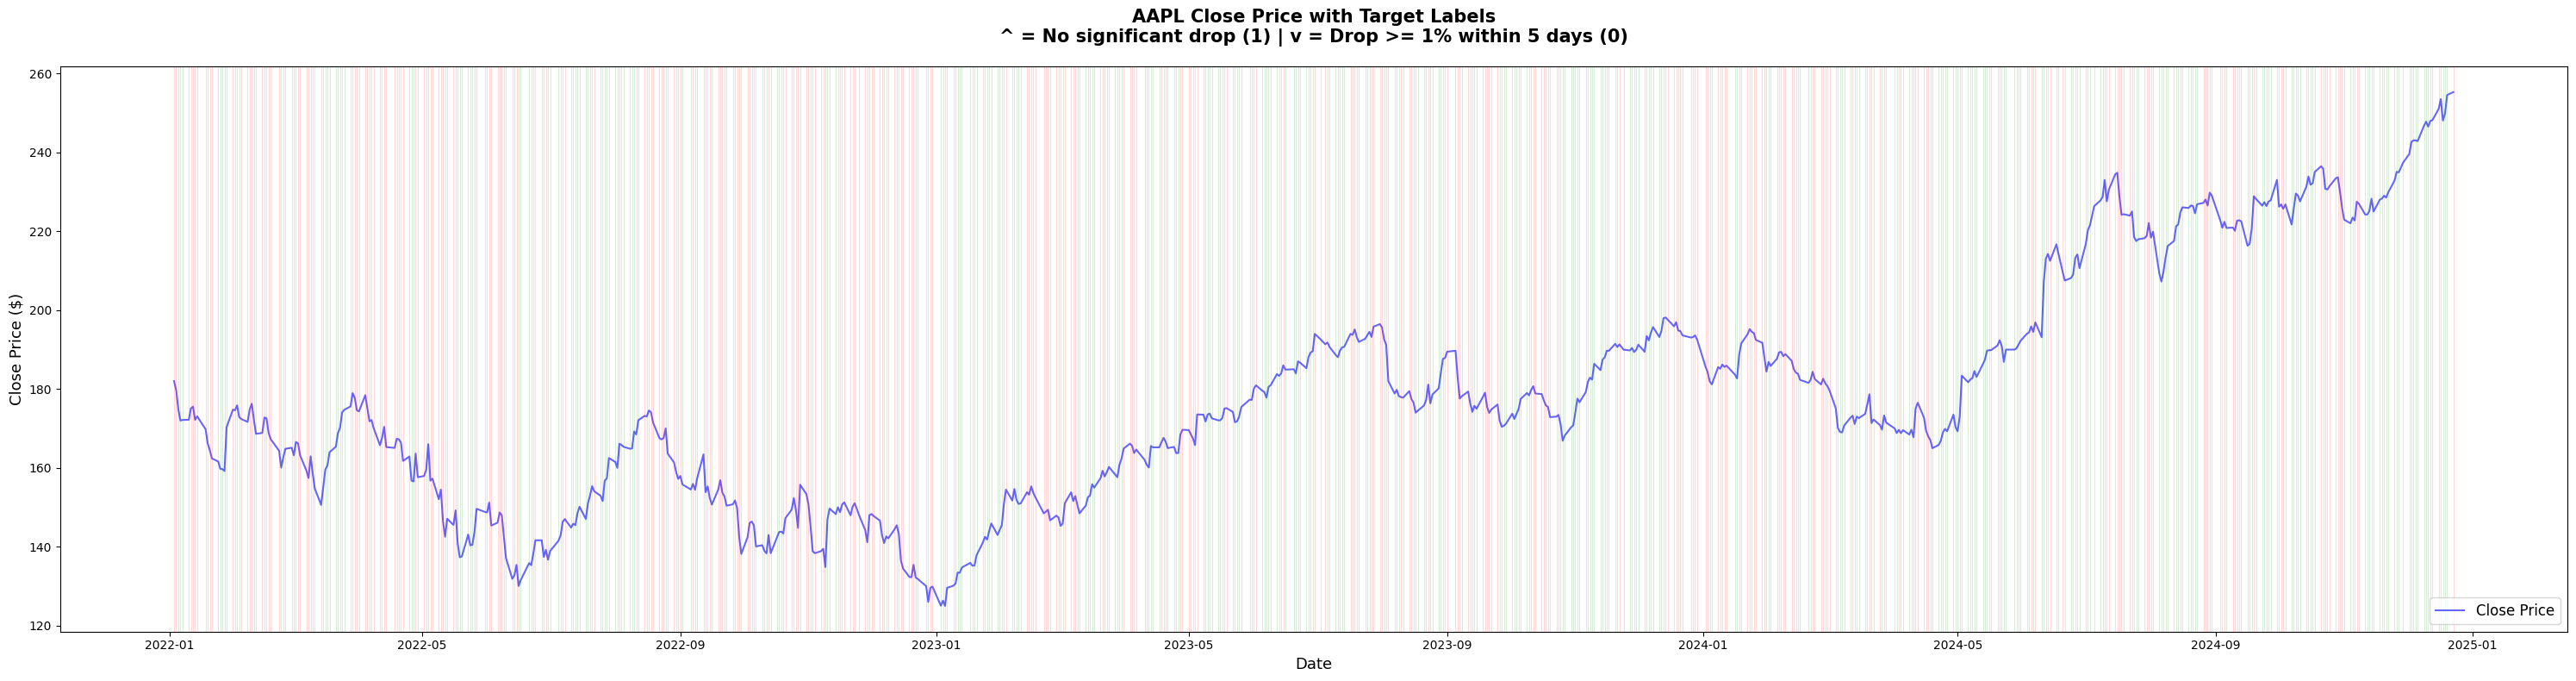

In [ ]:
stock = "AAPL"
TimeSplit_up = "2025-01-01"
TimeSplit_down = "2022-01-01"
start_dt = pd.to_datetime(TimeSplit_down)
end_dt = pd.to_datetime(TimeSplit_up)

df = pd.read_csv(
    f"csv/{stock}_indicators.csv",
    index_col=0,       # use first column ("Date") as index
    parse_dates=[0],    # parse it as datetime
    date_format="ISO8601" #Specify date format
) 

df = df[(df.index >= start_dt)&(df.index <= end_dt)]

X = df.copy()

def calculate_target(row_idx):
    if row_idx >= len(df) - 5:
        return np.nan  # Not enough future data
    
    start_price = df['Close'].iloc[row_idx]
    # Check the next 5 days
    future_prices = df['Close'].iloc[row_idx + 1:row_idx + 6]
    
    # Calculate percentage change from start price
    pct_changes = (future_prices - start_price) / start_price * 100
    
    # If any day drops by 1% or more, label as 0 (bearish)
    if (pct_changes <= -1.0).any():
        return 0
    else:
        return 1  # No significant drop (bullish/neutral)

df["Target"] = [calculate_target(i) for i in range(len(df))]

# Remove rows with NaN target (last 5 days)
df = df.dropna(subset=["Target"])
y = df["Target"].astype(int)

# Update X to match the filtered dataframe
X = X.loc[df.index]

print("Number of 1s in y (no drop):", (y == 1).sum())
print("Number of 0s in y (drop >= 1%):", (y == 0).sum())
print(f"Class balance: {(y == 1).sum() / len(y) * 100:.2f}% positive class")

plt.figure(figsize=(30, 8))

# Plot close prices
plt.plot(df.index, df['Close'], label='Close Price', color='blue', alpha=0.6, linewidth=1.5)

# Add markers for predictions with more spacing
ones = df[df['Target'] == 1]
zeros = df[df['Target'] == 0]

# Plot vertical lines for each day
for idx in df.index:
    if df.loc[idx, 'Target'] == 1:
        plt.axvline(x=idx, color='green', alpha=0.15, linewidth=0.8, linestyle='-')
    else:
        plt.axvline(x=idx, color='red', alpha=0.15, linewidth=0.8, linestyle='-')

# Add markers on top
#plt.scatter(ones.index, ones['Close'], marker='^', color='green', s=60, label='No Drop (1)', alpha=0.8, edgecolors='darkgreen', linewidths=1.5, zorder=5)
#plt.scatter(zeros.index, zeros['Close'], marker='v', color='red', s=60, label='Drop >= 1% (0)', alpha=0.8, edgecolors='darkred', linewidths=1.5, zorder=5)

plt.xlabel('Date', fontsize=13)
plt.ylabel('Close Price ($)', fontsize=13)
plt.title(f'{stock} Close Price with Target Labels', 
          fontsize=15, fontweight='bold', pad=20)
plt.legend(fontsize=12, loc='best')
plt.tight_layout()
plt.show()

In [17]:
#Scaling
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # manteniamo l'ordine temporale
)

print(y_train)

Date
2022-01-03    0
2022-01-04    0
2022-01-05    0
2022-01-06    1
2022-01-07    1
             ..
2024-05-14    1
2024-05-15    1
2024-05-16    0
2024-05-17    0
2024-05-20    0
Name: Target, Length: 598, dtype: int64


In [18]:
# 0.56, no erly stop
params = {
    'objective': 'binary:logistic',   # binary classification with logistic loss
    'eval_metric': 'logloss',         # loss function to track
    'booster': 'gbtree',
    'alpha': 1.0,                     # L1 regularization term
    'lambda': 0.0,                    # set L2 regularization to zero if pure L1 is desired
    'eta': 0.03,                      # learning rate
    'max_depth': 3,                  # depth of trees
    'subsample': 0.9,                # row sampling (helps reduce overfitting)
    'colsample_bytree': 0.9,        # feature sampling
    'scale_pos_weight': 0.8,         # Balanced the inputs
    'random_state': 42,
}

#0.57
params = {
    'objective': 'binary:logistic',   # binary classification with logistic loss
    'eval_metric': 'logloss',         # loss function to track
    'booster': 'gbtree',
    'alpha': 0.58,                     # L1 regularization term
    'lambda': 0.0,                    # set L2 regularization to zero if pure L1 is desired
    'eta': 0.026,                      # learning rate
    'max_depth': 3,                  # depth of trees
    'subsample': 0.6,                # row sampling (helps reduce overfitting)
    'colsample_bytree': 0.84,        # feature sampling
    'scale_pos_weight': 0.8,         # Balanced the inputs
    'random_state': 42,
}
#temp
params = {
    'objective': 'binary:logistic',   # binary classification with logistic loss
    'eval_metric': 'logloss',         # loss function to track
    'booster': 'gbtree',
    'alpha': 0.8,                     # L1 regularization term
    'lambda': 0.0,                    # set L2 regularization to zero if pure L1 is desired, (useless)
    'eta': 0.026,                      # learning rate
    'max_depth': 5,                  # depth of trees
    'subsample': 0.8,                # row sampling (helps reduce overfitting)
    'colsample_bytree': 0.82,        # feature sampling
    'scale_pos_weight': 1.1,         # Balanced the inputs
    'random_state': 42,
}

# 0.59 but bias towrds 1
params = {
    'objective': 'binary:logistic',   # binary classification with logistic loss
    'eval_metric': 'logloss',         # loss function to track
    'booster': 'gbtree',
    'alpha': 0.58,                     # L1 regularization term
    'lambda': 0.0,                    # set L2 regularization to zero if pure L1 is desired
    'eta': 0.026,                      # learning rate
    'max_depth': 6,                  # depth of trees
    'subsample': 0.7,                # row sampling (helps reduce overfitting)
    'colsample_bytree': 0.8,        # feature sampling
    'scale_pos_weight': 1.244,         # Balanced the inputs
    'random_state': 42,
}

# 0.6 35 early, bias towrds 0
params = {
    'objective': 'binary:logistic',   # binary classification with logistic loss
    'eval_metric': 'logloss',         # loss function to track
    'booster': 'gbtree',
    'alpha': 0.7,                     # L1 regularization term
    'lambda': 0.0,                    # set L2 regularization to zero if pure L1 is desired
    'eta': 0.02,                      # learning rate
    'max_depth': 5,                  # depth of trees
    'subsample': 0.5,                # row sampling (helps reduce overfitting)
    'colsample_bytree': 0.8,        # feature sampling
    'scale_pos_weight': 0.85,         # Balanced the inputs
    'random_state': 42,
}

params = {
    'objective': 'binary:logistic',   # binary classification with logistic loss
    'eval_metric': 'logloss',         # loss function to track
    'booster': 'gbtree',
    'alpha': 0.7,                     # L1 regularization term
    'lambda': 0.0,                    # set L2 regularization to zero if pure L1 is desired
    'eta': 0.025,                      # learning rate
    'max_depth': 4,                  # depth of trees
    'subsample': 0.8,                # row sampling (helps reduce overfitting)
    'colsample_bytree': 0.8,        # feature sampling
    'scale_pos_weight': 1.1,         # Balanced the inputs
    'random_state': 42,
}


## AAPL, 20 iert ggod start
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'booster': 'dart',
    'eta': 0.02,
    'max_depth': 5,
    'alpha': 1.0,          # stronger L1
    'lambda': 1.5,         # add L2
    'min_child_weight': 3, # helps avoid overfitting on outliers
    'subsample': 0.7,
    'colsample_bytree': 0.8,
    'rate_drop': 0.4,
    'skip_drop': 0.3,     
    'scale_pos_weight': 0.8,
    'random_state': 42
} 

# 0.52 22 iter
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'booster': 'dart',
    'eta': 0.02,
    'max_depth': 6,
    'alpha': 1.0,          # stronger L1
    'lambda': 1.5,         # add L2
    'min_child_weight': 3, # helps avoid overfitting on outliers
    'subsample': 0.7,
    'colsample_bytree': 0.8,
    'rate_drop': 0.4,
    'skip_drop': 0.3,     
    'scale_pos_weight': 0.8,
    'random_state': 42
} 

# 9 stopping rounds
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'booster': 'dart',
    'eta': 0.015478090569556893,
    'max_depth': 3,
    'lambda': 0.19178079480833618,
    'alpha': 9.926201380826244,
    'subsample': 0.726399759111481,
    'colsample_bytree': 0.6841328527493009,
    'scale_pos_weight': 0.8887500386854902,
}

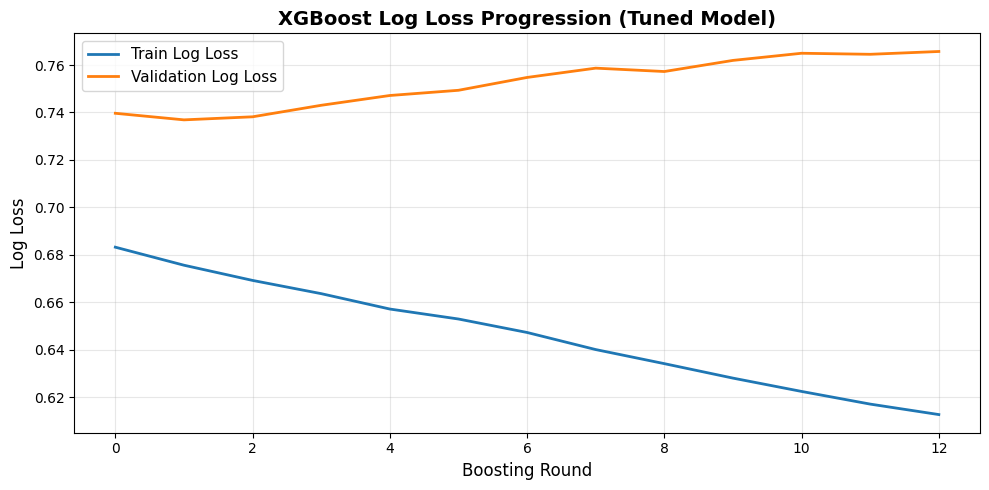


Best iteration: 1
Number of boosting rounds used: 13

FINAL MODEL EVALUATION: best threshold: 0.3899999999999999

Classification Report:
              precision    recall  f1-score   support

           1       0.88      0.24      0.38        90
           0       0.46      0.95      0.62        60

    accuracy                           0.53       150
   macro avg       0.67      0.60      0.50       150
weighted avg       0.71      0.53      0.48       150


Accuracy: 0.5267
Final Validation Log Loss: 0.7657


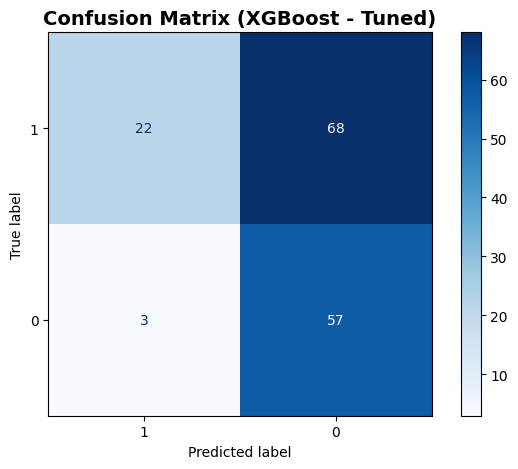

In [19]:
neg, pos = np.sum(y_train == 0), np.sum(y_train == 1)

params = {
    'eta': 0.029562034936838524,
    'max_depth': 4,
    'lambda': 1.127595806095064,
    'alpha': 0.4660587036949967,
    'subsample': 0.6084605503854795,
    'colsample_bytree': 0.7819449755536887,
    'gamma': 1.5280679118494158,
    'scale_pos_weight': 0.8769643899488392,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'random_state': 42,
}

num_rounds = 800 # number of max boosting iterations

# Convert to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_test, label=y_test)

# Train with evaluation for each iteration
evals = [(dtrain, 'train'), (dval, 'validation')]
evals_result = {}

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_rounds,
    evals=evals,
    evals_result=evals_result,
    verbose_eval=False,
    early_stopping_rounds=11
)

# Plot the Loss Curve
train_logloss = evals_result['train']['logloss']
val_logloss = evals_result['validation']['logloss']

plt.figure(figsize=(10, 5))
plt.plot(train_logloss, label='Train Log Loss', linewidth=2)
plt.plot(val_logloss, label='Validation Log Loss', linewidth=2)
plt.xlabel('Boosting Round', fontsize=12)
plt.ylabel('Log Loss', fontsize=12)
plt.title('XGBoost Log Loss Progression (Tuned Model)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nBest iteration: {model.best_iteration}")
print(f"Number of boosting rounds used: {len(train_logloss)}")

# Final Evaluation
y_pred_proba = model.predict(dval)
best_mcc = -1
best_threshold = 0.5
for threshold in np.arange(0.1, 0.9, 0.01):
    preds = (y_pred_proba > threshold).astype(int)
    mcc = matthews_corrcoef(y_test, preds)
    if mcc > best_mcc:
        best_mcc = mcc
        best_threshold = threshold

y_pred = (y_pred_proba >= best_threshold).astype(int)

print("\n" + "="*60)
print(f"FINAL MODEL EVALUATION: best threshold: {best_threshold}")
print("="*60)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, labels=[1, 0]))

print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Final Validation Log Loss: {log_loss(y_test, y_pred_proba):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (XGBoost - Tuned)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
num_rounds = 800
early_stop = 10

Starting hyperparameter optimization with Optuna...


  0%|          | 0/100 [00:00<?, ?it/s]

Best trial: 14. Best value: 0.323241: 100%|██████████| 100/100 [00:09<00:00, 10.34it/s]



BEST HYPERPARAMETERS
Best Obj Function: 0.3232

Best parameters:
  eta: 0.2520494460612013
  max_depth: 4
  lambda: 0.9417157566623993
  alpha: 3.054475759553677
  subsample: 0.8163178745935351
  colsample_bytree: 0.8309526955065967
  gamma: 1.118337573273918
  scale_pos_weight: 1.2403817553390144


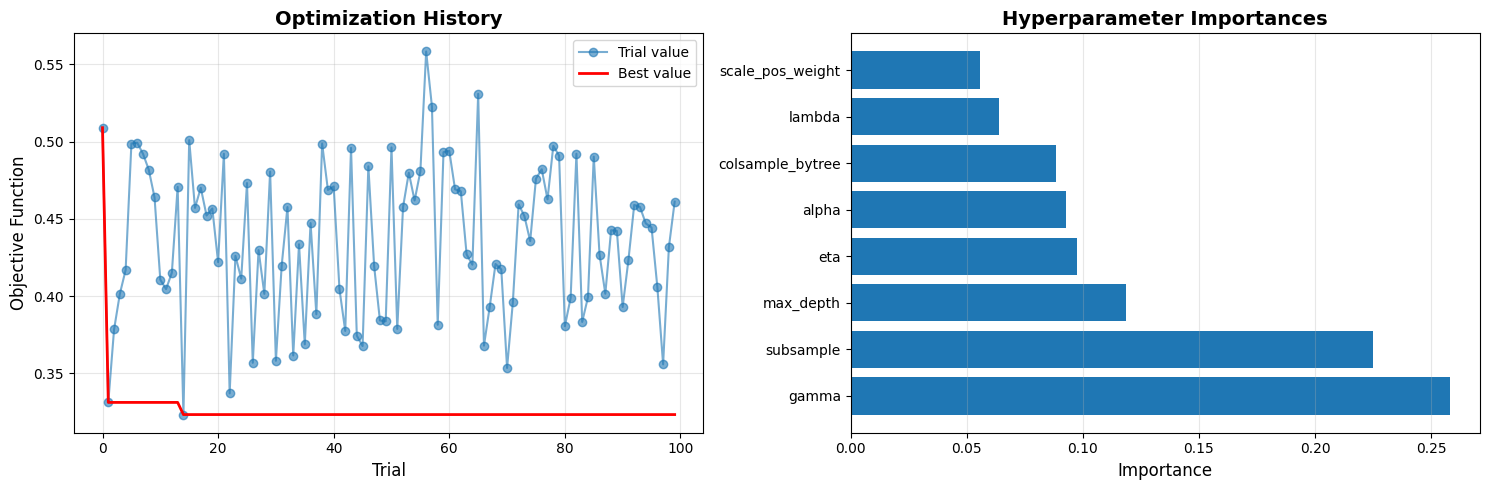

In [ ]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)


def objective(trial: optuna.trial.Trial) -> float:
    params_trial = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'booster': 'gbtree',  # Start with the more stable gbtree
        'eta': trial.suggest_float('eta', 0.01, 0.5, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 4),
        'lambda': trial.suggest_float('lambda', 0.1, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 0.1, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'gamma': trial.suggest_float('gamma', 0, 5.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.9 * poswight, 1.1* poswight),
        'random_state': 42,
    }

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_test, label=y_test)

    model = xgb.train(
        params=params_trial,
        dtrain=dtrain,
        num_boost_round=num_rounds,
        evals=[(dval, 'validation')],
        early_stopping_rounds=early_stop,
        verbose_eval=False
    )

    preds_proba = model.predict(dval, iteration_range=(0, model.best_iteration))

    # We want to maximize AUC, so for Optuna's minimization, return 1.0 - auc
    auc = roc_auc_score(y_test, preds_proba)
    return float(1.0 - auc)

print("Starting hyperparameter optimization with Optuna...")
study = optuna.create_study(direction='minimize', study_name='xgboost_tuning')
study.optimize(objective, n_trials=100, show_progress_bar=True)

# Print best results
print("\n" + "="*60)
print("BEST HYPERPARAMETERS")
print("="*60)
print(f"Best Obj Function: {study.best_value:.4f}")
print("\nBest parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# Visualize optimization history with matplotlib
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot optimization history
trials = study.trials
trial_numbers = [t.number for t in trials]
trial_values = [t.value for t in trials]

# Handle possible None values returned by incomplete/failed trials:
# - use +inf for min computation so None values don't interfere
# - use np.nan for plotting so matplotlib will skip them
numeric_for_min = [v if v is not None else float('inf') for v in trial_values]
plot_values = [v if v is not None else np.nan for v in trial_values]

best_values = [min(numeric_for_min[:i+1]) for i in range(len(numeric_for_min))]

ax1.plot(trial_numbers, plot_values, 'o-', alpha=0.6, label='Trial value')
ax1.plot(trial_numbers, best_values, 'r-', linewidth=2, label='Best value')
ax1.set_xlabel('Trial', fontsize=12)
ax1.set_ylabel('Objective Function', fontsize=12)
ax1.set_title('Optimization History', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot parameter importances
importances = optuna.importance.get_param_importances(study)
params_names = list(importances.keys())
params_values = list(importances.values())

ax2.barh(params_names, params_values)
ax2.set_xlabel('Importance', fontsize=12)
ax2.set_title('Hyperparameter Importances', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


Copy these parameters to cell 7:
params = {
    'eta': 0.2520494460612013,
    'max_depth': 4,
    'lambda': 0.9417157566623993,
    'alpha': 3.054475759553677,
    'subsample': 0.8163178745935351,
    'colsample_bytree': 0.8309526955065967,
    'gamma': 1.118337573273918,
    'scale_pos_weight': 1.2403817553390144,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'random_state': 42,
}

Training final model with best parameters...


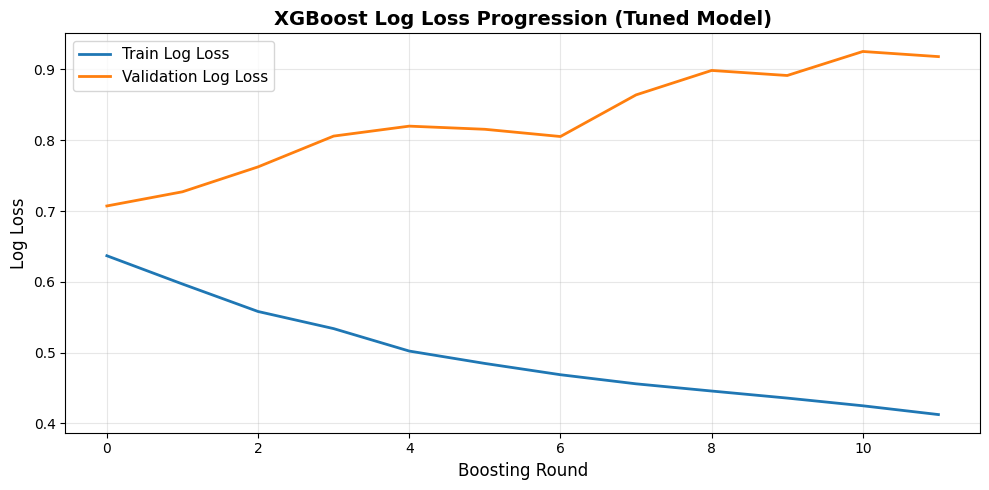


Best iteration: 0
Number of boosting rounds used: 12

FINAL MODEL EVALUATION: best threshold: 0.2699999999999999

Classification Report:
              precision    recall  f1-score   support

           1       0.78      0.48      0.59        90
           0       0.51      0.80      0.62        60

    accuracy                           0.61       150
   macro avg       0.64      0.64      0.61       150
weighted avg       0.67      0.61      0.60       150


Accuracy: 0.6067
Final Validation Log Loss: 0.9181


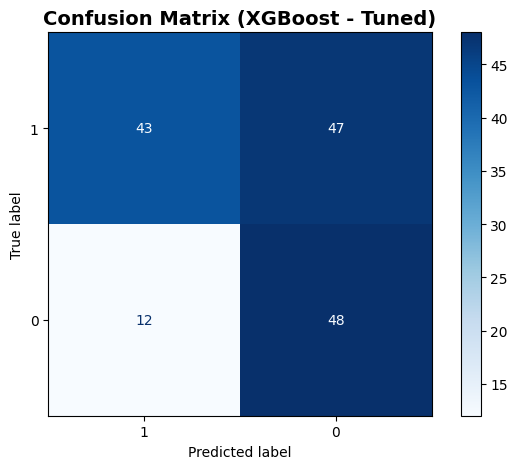

In [ ]:
# Use best parameters from Optuna
best_params = study.best_params.copy()
best_params['objective'] = 'binary:logistic'
best_params['eval_metric'] = 'logloss'
best_params['random_state'] = 42

print("\nCopy these parameters to cell 7:")
print("="*60)
print("best_params = {")
for k, v in best_params.items():
    print(f"    '{k}': {repr(v)},")
print("}")
print("="*60)


print("\nTraining final model with best parameters...")
print("="*60)

# Convert to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_test, label=y_test)

# Train with evaluation for each iteration

evals_result = {}

model = xgb.train(
    params=best_params,
    dtrain=dtrain,
    num_boost_round=num_rounds,
    evals=evals,
    evals_result=evals_result,
    verbose_eval=False,
    early_stopping_rounds=11
)

# Plot the Loss Curve
train_logloss = evals_result['train']['logloss']
val_logloss = evals_result['validation']['logloss']

plt.figure(figsize=(10, 5))
plt.plot(train_logloss, label='Train Log Loss', linewidth=2)
plt.plot(val_logloss, label='Validation Log Loss', linewidth=2)
plt.xlabel('Boosting Round', fontsize=12)
plt.ylabel('Log Loss', fontsize=12)
plt.title('XGBoost Log Loss Progression (Tuned Model)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nBest iteration: {model.best_iteration}")
print(f"Number of boosting rounds used: {len(train_logloss)}")

# Final Evaluation
y_pred_proba = model.predict(dval)
best_mcc = -1
best_threshold = 0.5
for threshold in np.arange(0.1, 0.9, 0.01):
    preds = (y_pred_proba > threshold).astype(int)
    mcc = matthews_corrcoef(y_test, preds)
    if mcc > best_mcc:
        best_mcc = mcc
        best_threshold = threshold

y_pred = (y_pred_proba >= best_threshold).astype(int)

print("\n" + "="*60)
print(f"FINAL MODEL EVALUATION: best threshold: {best_threshold}")
print("="*60)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, labels=[1, 0]))

print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Final Validation Log Loss: {log_loss(y_test, y_pred_proba):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (XGBoost - Tuned)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
import os
import joblib

os.makedirs("models", exist_ok=True)

artifact = {
    "model": model,
    "features": X_train.columns.tolist() if hasattr(X_train, "columns") else None,
    "threshold" : best_threshold
}

out_path = f"models/{stock}.joblib"
joblib.dump(artifact, out_path)

['models/AAPL.joblib']